In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import json

In [2]:
#загружаем базу
imgDir = "urbanhack-train/images"
annFile = "urbanhack-train/annotations/instances_default.json"
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [3]:
#информация  о самом датасете отсутствует, есть только фото и их аннотации, с ними и будем работать
coco.info()

contributor: 
date_created: 
description: 
url: 
version: 
year: 


## 0. Создаем датафрейм из файла COCO (возможно, нам это пригодится)

In [4]:
#загружаем аннотации
df_anns = pd.DataFrame(coco.anns).T
df_anns.set_index("id", inplace=True)
#из attributes уникальные значения есть только в 'rotation'
df_anns["rotation"] = df_anns["attributes"].apply(lambda x: list(x.values())[1])
#удаляем ПУСТЫЕ колонки
df_anns.drop(columns=["segmentation", "iscrowd", "attributes"], inplace=True)
#df_anns.info()
df_anns.head()

,image_id,category_id,area,bbox,rotation
id,,,,,
1,1,2,12677.0917,"[98.87, 141.25, 110.63, 114.59]",0.0
2,1,2,16279.1769,"[723.17, 184.07, 130.83, 124.43]",0.0
3,1,2,13944.2534,"[475.7, 48.84, 116.62, 119.57]",0.0
4,1,2,13847.1183,"[593.81, 62.38, 118.89, 116.47]",0.0
5,1,2,10862.957,"[0.0, 259.95, 81.34, 133.55]",0.0


In [5]:
#загружаем информацию по изображениям
df_images = pd.DataFrame(coco.imgs).T
df_images.rename({"id" : "image_id"}, axis=1, inplace=True)
df_images.set_index("image_id", inplace=True)
#удаляем ПУСТЫЕ колонки
df_images.drop(columns=["license", "flickr_url", "coco_url", "date_captured"], inplace=True)
#df_images.info()
df_images.head()

,width,height,file_name
image_id,,,
1,854,572,0000019949building.jpg
2,881,720,0000019869building.jpg
3,847,544,0000019458building.jpg
4,303,600,0000019455building.jpg
5,869,676,0000019431building.jpg


In [6]:
df_cats = pd.DataFrame(coco.cats).T
df_cats.rename({"id" : "category_id"}, axis=1, inplace=True)
df_cats.set_index("category_id", inplace=True)
df_cats.drop(columns="supercategory",inplace=True)
df_cats.head()

,name
category_id,
1,window
2,empty
3,filled


In [7]:
#объединяем все данные в одну таблицу
df = df_anns
df = df.merge(right=df_images, left_on="image_id", right_index=True)
df = df.merge(right=df_cats, left_on="category_id", right_index=True)
#отказался от дропа, так как эти колонки содержат id каждого bbox, может пригодится позже
#df.drop(columns=["image_id", "category_id"], inplace=True)
df.rename({"name" : "category"}, axis=1, inplace=True)
df.rename({"file_name" : "filename"}, axis=1, inplace=True)
#df.info()
df.head()

,image_id,category_id,area,bbox,rotation,width,height,filename,category
id,,,,,,,,,
1,1,2,12677.0917,"[98.87, 141.25, 110.63, 114.59]",0.0,854,572,0000019949building.jpg,empty
2,1,2,16279.1769,"[723.17, 184.07, 130.83, 124.43]",0.0,854,572,0000019949building.jpg,empty
3,1,2,13944.2534,"[475.7, 48.84, 116.62, 119.57]",0.0,854,572,0000019949building.jpg,empty
4,1,2,13847.1183,"[593.81, 62.38, 118.89, 116.47]",0.0,854,572,0000019949building.jpg,empty
5,1,2,10862.957,"[0.0, 259.95, 81.34, 133.55]",0.0,854,572,0000019949building.jpg,empty


In [8]:
#нужно с этим разобраться, см. вывод
df[(df["rotation"] != 0)]["filename"].value_counts()

filename
0000035095building.jpg    4
0000035089building.jpg    2
0000035087building.jpg    2
0000033910building.jpg    1
0000033907building.jpg    1
0000018897building.jpg    1
Name: count, dtype: int64

**Вывод**:

Прочитали данные из базы данных COCO, так как они хранились в разных таблицах, то мы их объединили. Предаварительно, из данных были удалены столбцы, которые не несли смысловой нагрузки.

**Описание данных**:

`area` - площадь bbox (bounding box или bbox- это прямоугольник, размеченная область фотографии, которой мы и присваиваем класс, на одной фотографии можеть несколько bbox) \
`bbox` - координаты прямоугольника bounding box (x, y, width, height), координаты отсчитываются с левого верхнего угла \
`rotation` - вероятно, это поворот bbox (не здания, а самого bbox на фотографии), в датасете у нас всего лишь 11 таких повернутых(?) bbox (они есть в 6-ти фотографиях) \
`width` - ширина самой фотографии (а не bbox!)\
`height` - высота самой фотографии (а не bbox!)\
`filename` - имя файла фотографии из папки *images*\
`category` - класс объекта, то есть класс bbox, он может быть `empty` (пустой), `window` (окно) или `filled` (кладка?)

Что было удалено:\
`supercategory` - суперкатегория (у нас ее/их нет), например категории могут быть - олени, лоси, коровы, а суперкатегория для них - парнокопытные, но у нас такого деления нет\
`license`, `flickr_url`, `coco_url`, `date_captured` - пустые признаки у каждого bbox\
`segmentation` - пусто (вообще, нужен для задачи сегментации)\
`iscrowd` - у всех объектов установлена в ноль, вероятно, связана с `segmentation`\
`attributes` - внутри этого признака были подпризнаки `occluded`: False (у всех bbox одинаковый и поэтому был удален), `rotation` - оставлен


P. S. Описание данных можно посмотреть здесь https://cocodataset.org/#format-data (раздел **1. Object Detection**), однако там нет `rotation`.

## 1. Непосредтственная работа с COCO API

In [15]:
#список id всех изображений
imgIds = coco.getImgIds()
print(f"{imgIds=}")
#загружаем все изображаения по их id
imgs = coco.loadImgs(imgIds)
print("Формат данных изображений - список словарей:")
print(f"{json.dumps(imgs[:2], indent=4)}")

imgIds=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

id аннотаций изображения 0000019949building.jpg: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Аннотации:[
    {
        "id": 1,
        "image_id": 1,
        "category_id": 2,
        "segmentation": [],
        "area": 12677.091699999999,
        "bbox": [
            98.87,
            141.25,
            110.63,
            114.59
        ],
        "iscrowd": 0,
        "attributes": {
            "occluded": false,
            "rotation": 0.0
        }
    },
    {
        "id": 2,
        "image_id": 1,
        "category_id": 2,
        "segmentation": [],
        "area": 16279.176900000006,
        "bbox": [
            723.17,
            184.07,
            130.83,
            124.43
        ],
        "iscrowd": 0,
        "attributes": {
            "occluded": false,
            "rotation": 0.0
        }
    },
    {
        "id": 3,
        "image_id": 1,
        "category_id": 2,
        "segmentation": [],
        "area": 13944.253400000007,


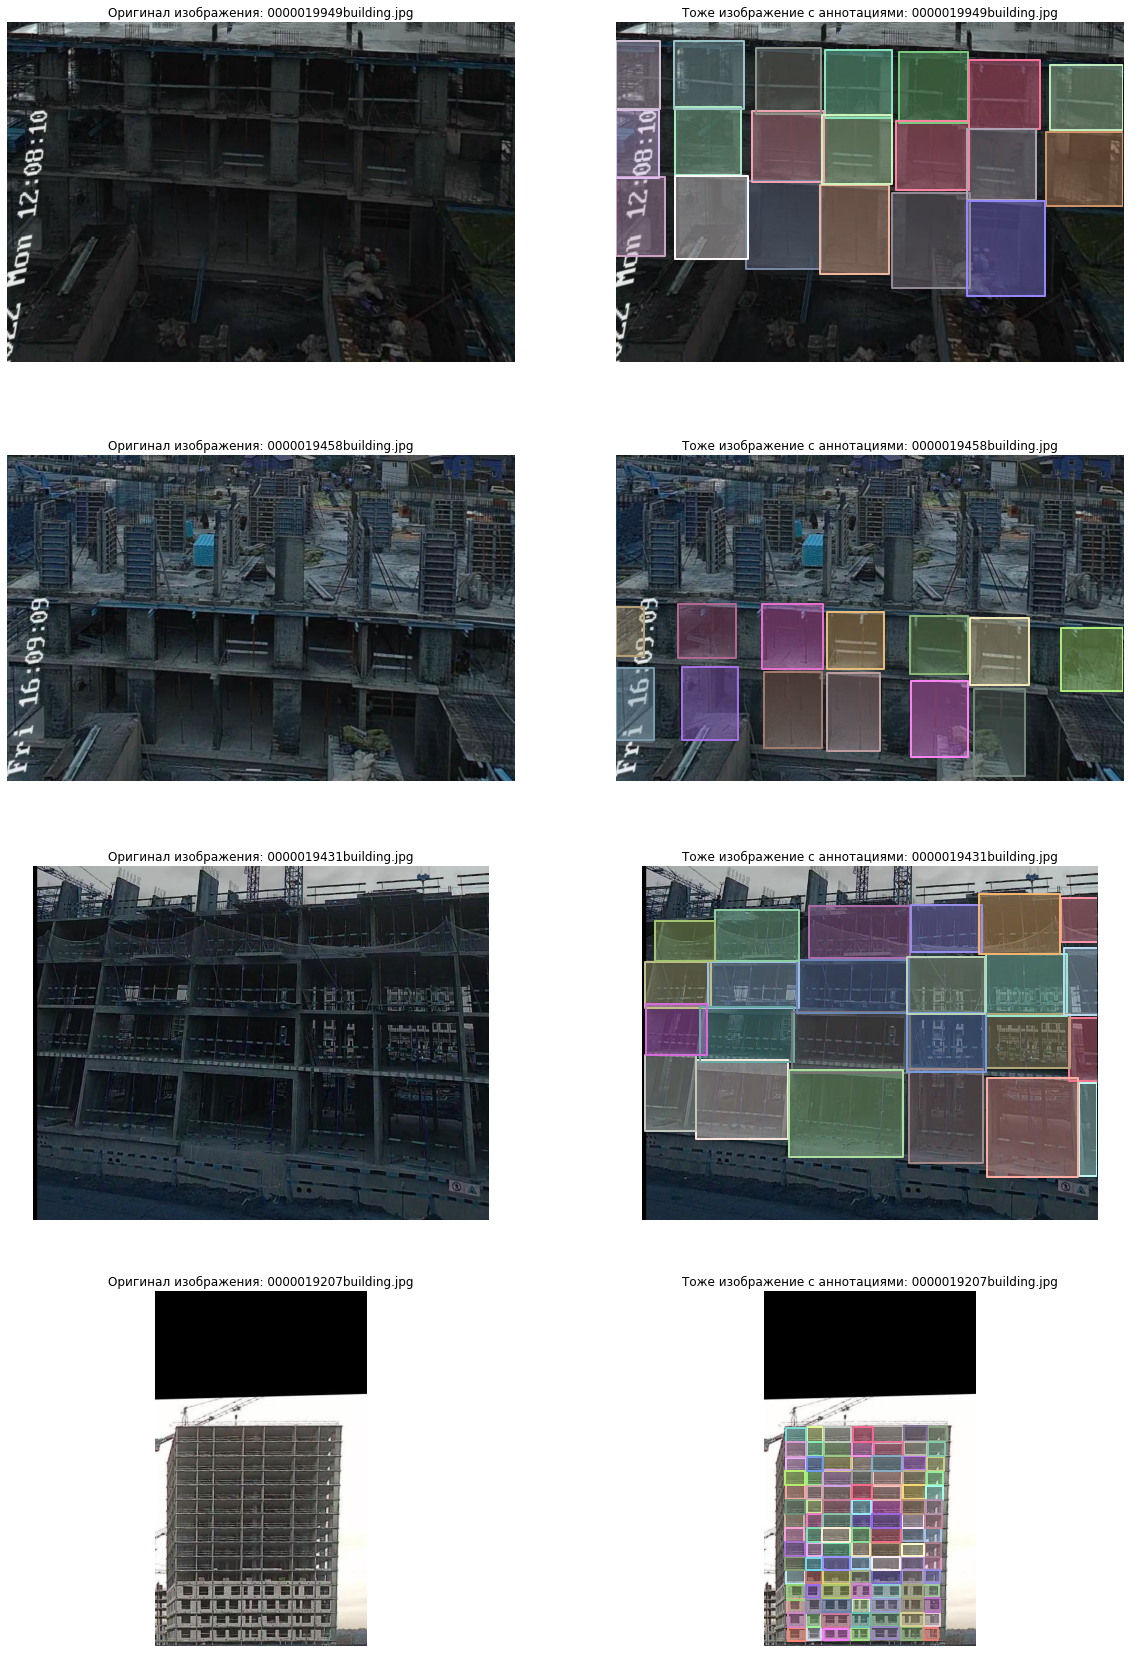

In [29]:
fig, ax = plt.subplots(nrows=4, ncols=2)
ax = ax.ravel()
fig.set_size_inches(20,30)

for i in range(0, 8, 2):
    img = imgs[i]
    im = cv2.imread(f"{imgDir}/{img['file_name']}")
    ax[i].axis('off')
    ax[i+1].axis('off')
    
    #само изображение
    ax[i].imshow(im)
    ax[i].set_title(f"Оригинал изображения: {img['file_name']}")
    #изображение с аннотациями (bbox)
    ax[i+1].imshow(im)
    ax[i+1].set_title(f"Тоже изображение с аннотациями: {img['file_name']}")
    #похоже у COCO нельзя вывести изображение на конкретный Axes
    plt.sca(ax[i+1])
    #получаем список id всех аннотация для конкретного id изображения
    annIds = coco.getAnnIds(imgIds=img['id'])
    print(f"id аннотаций изображения {img['file_name']}: {annIds}")
    #загружаем сами аннотации, используя список id для каждого изображения
    anns = coco.loadAnns(annIds)
    print(f"Аннотации:{json.dumps(anns, indent=4)}")
    #метод COCO API для визуализации изображения и аннотаций
    coco.showAnns(anns, draw_bbox=True)
plt.show()